In [1]:
import re
import datetime
from glob import glob 
import os 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from method import * 

file_paths = glob('/Volume/VAD/LifeLongerAD_cu121/results/*/MVTecAD/*/seed_42/results/main.csv')

results = {fp.split('/')[-6]+'-' + fp.split('/')[-4] : pd.read_csv(fp) for fp in file_paths}

# 메인 성능 

In [2]:
df = pd.DataFrame()

for k,v in results.items():
    try: 
        v.loc[v['class_name']=='AA']
        temp = v.loc[v['class_name']=='AA'].drop(columns=['Unnamed: 0','last'])
        temp['method'] =k.split('-')[0]
        temp['Continual'] = k.split('-')[-2].split('_')[-1]
        temp['Online'] = k.split('-')[-1].split('_')[-1]
        
        df = pd.concat([df,temp])
    except:
        temp = pd.DataFrame(v.drop(columns=['Unnamed: 0','GT_class_name']).mean()).T
        temp['method'] =k.split('-')[0]
        temp['Continual'] = k.split('-')[-2].split('_')[-1]
        temp['Online'] = k.split('-')[-1].split('_')[-1]
        df = pd.concat([df,temp])

In [3]:
df[df['method']=='ReverseDistillation'].pivot_table(index=['Continual','Online'],values=['img_level_auroc','img_level_average_precision','pix_level_auroc','pix_level_average_precision'])

img_level_auroc  img_level_average_precision  \
Continual Online                                                 
False     False          0.973229                     0.989514   
          True           0.833880                     0.924117   
True      False          0.736047                     0.875363   
          True           0.673090                     0.831343   

                  pix_level_auroc  pix_level_average_precision  
Continual Online                                                
False     False          0.972170                     0.583079  
          True           0.933336                     0.417979  
True      False          0.823885                     0.255135  
          True           0.786981                     0.188960

# 메인 성능 변화 

In [4]:
file_paths = glob('/Volume/VAD/LifeLongerAD_cu121/results/ReverseDistillation/MVTecAD/*/seed_42/results/result_log.csv')

results = {fp.split('/')[-6]+'-' + fp.split('/')[-4] : pd.read_csv(fp) for fp in file_paths}

In [5]:
metric_list = ['img_level_auroc','img_level_average_precision','pix_level_auroc','pix_level_average_precision']

def cal_results_continual_true(df):
    cln_results = {} 
    for cln in class_name:
        temp = df[(df['last']==1) & (df['class_name']==cln)]    
        cln_results[cln] = temp[metric_list].mean(1).values
    return cln_results     

exp_results = {}
for exp_name, df in results.items():
    class_name = df['class_name'].unique()
    
    if df['last'].sum()>0: # continual on 
        cln_results = cal_results_continual_true(df)
        exp_results[exp_name] = cln_results
    elif df['last'].sum()==0: # continual off 
        
        pass 
    
    

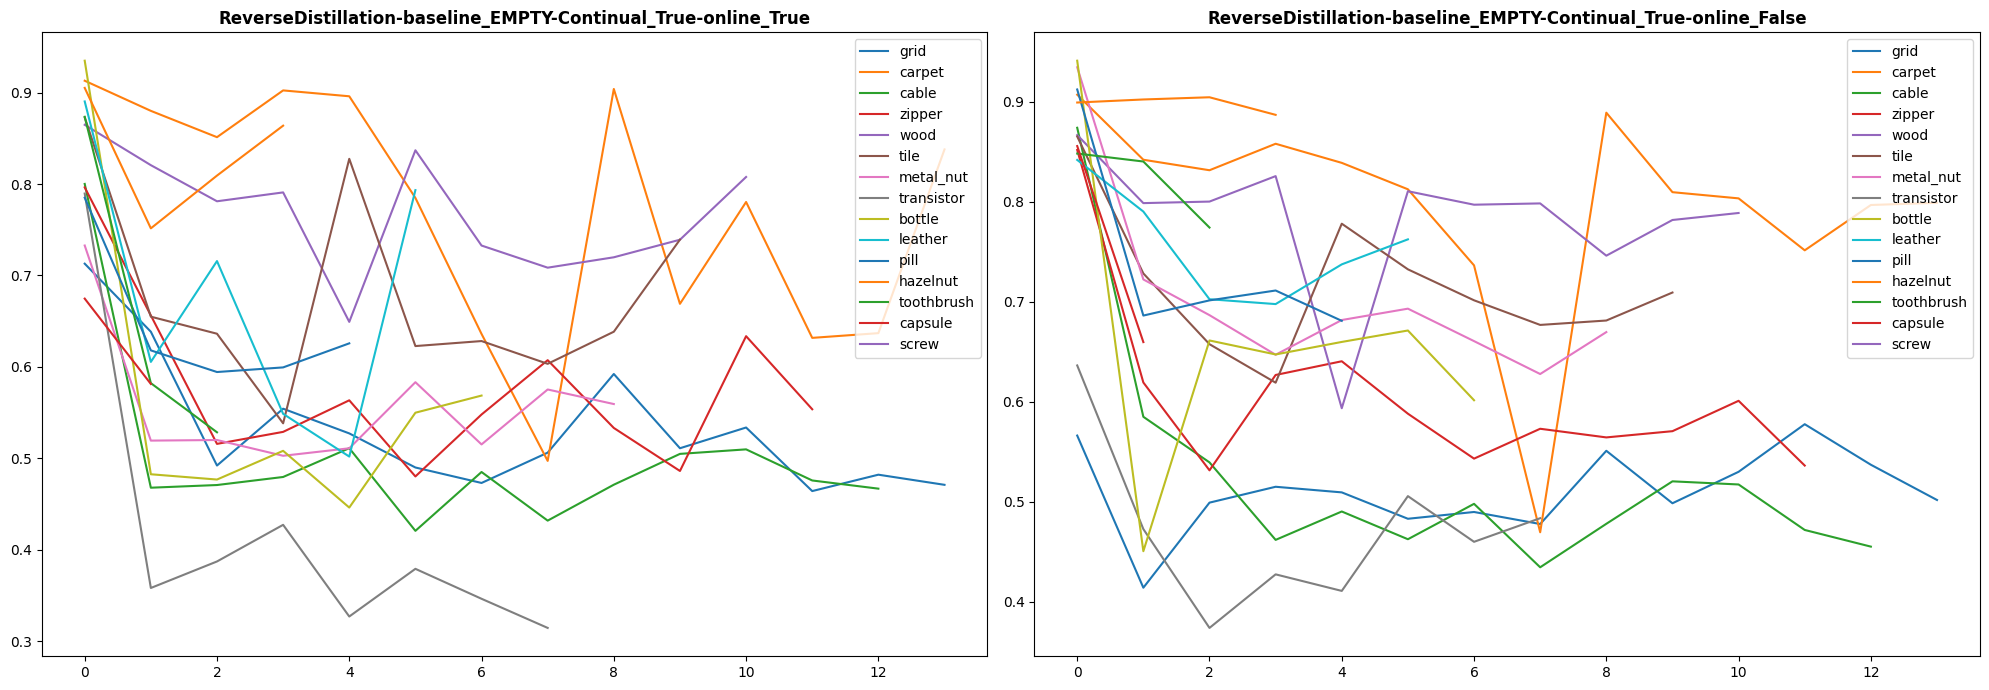

In [6]:

fig,axes = plt.subplots(1,2, figsize=(20,7))

for i,(exp_name, df) in enumerate(exp_results.items()):
    
    for cln, results in df.items():
        sns.lineplot(
            results[1:],
            ax = axes[i],
            label = cln 
        )
    
    axes[i].set_title(exp_name,weight='bold')
plt.tight_layout()
plt.show()

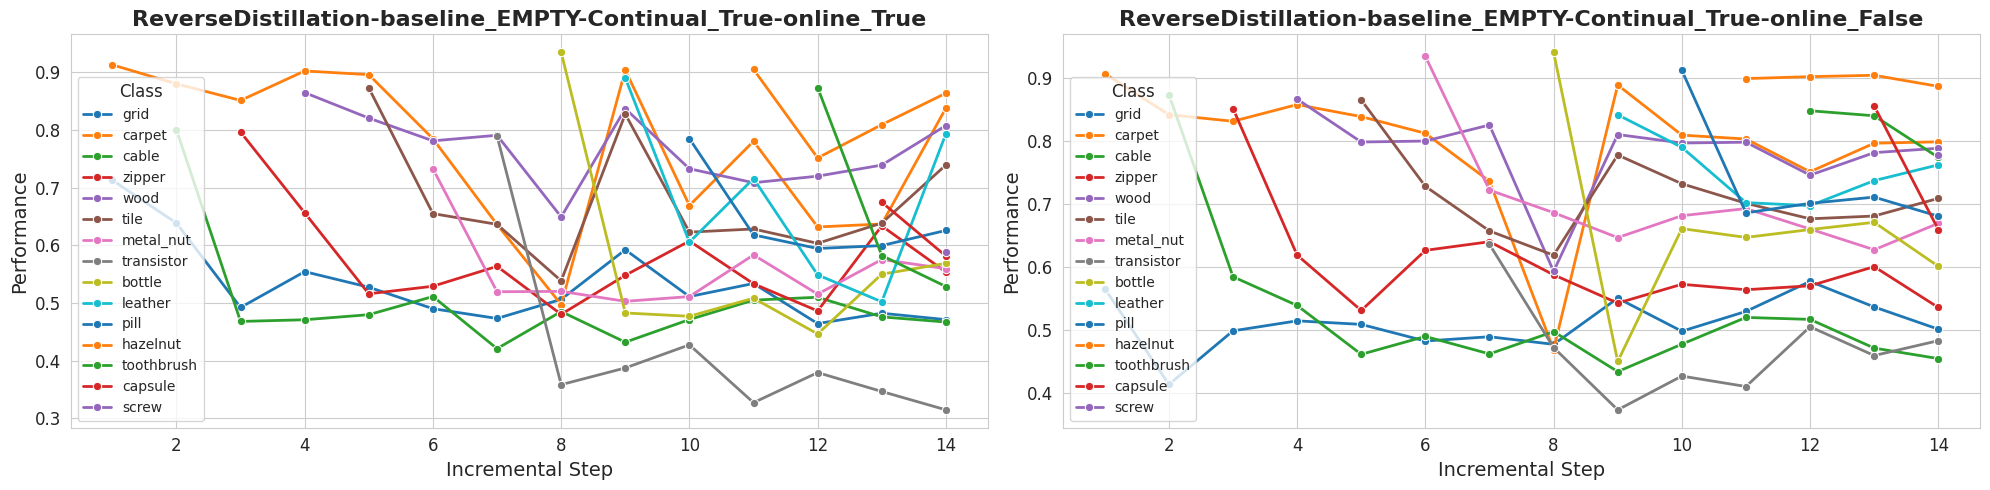

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(20, 5))

for i, (exp_name, df) in enumerate(exp_results.items()):
    for cln, results in df.items():
        x_vals = range(15 - len(results[1:]), 15)
        sns.lineplot(x=x_vals, y=results[1:], ax=axes[i], label=cln, marker="o", linewidth=2)
    
    axes[i].set_title(exp_name, weight='bold', fontsize=16)
    axes[i].set_xlabel("Incremental Step", fontsize=14)
    axes[i].set_ylabel("Performance", fontsize=14)
    axes[i].tick_params(axis="both", labelsize=12)
    
    # 중복 legend 항목 제거 후, 폰트 크기 조정
    handles, labels = axes[i].get_legend_handles_labels()
    unique = dict(zip(labels, handles))
    axes[i].legend(unique.values(), unique.keys(), title="Class", fontsize=10, title_fontsize=12, loc='best')

plt.tight_layout()
plt.show()
